## Question 1

As per https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html
- CPU Make: Intel(R) Core(TM) i7-9750H 
- Number of Physical Cores: 6
- Base Frequency: 2.60 GHz
- Turbo (Maximum) Frequency: 4.50 GHz (1 core),  3.20 GHz (6 core)

## References: 

1. https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html
2. https://psref.lenovo.com/syspool/Sys/PDF/Legion/Lenovo_Legion_Y740_15IRHg/Lenovo_Legion_Y740_15IRHg_Spec.pdf
3. https://www.intel.com/content/www/us/en/products/docs/processors/core/8th-gen-core-family-datasheet-vol-1.html
4. https://www.intel.com/content/www/us/en/products/docs/processors/core/8th-gen-core-family-datasheet-vol-2.html
5. https://www.cpu-monkey.com/en/cpu-intel_core_i7_9750h

## Question 2

As per Performance GUI of Windows Task Manager
- L1 Cache Size: 384kB = 6 * 64 kB
- L2 Cache Size: 1.5 MB = 6 * 256 kB 
- L3 Cache Size: 12.0 MB

### Sharing of the caches 

As per the https://www.intel.com/content/www/us/en/products/docs/processors/core/8th-gen-core-family-datasheet-vol-1.html
> Each execution core has an instruction cache, data cache, and 256-KB L2 cache. All execution cores share the LLC (L3 cache).

- Thus each core has its own 32kB L1 instruction and 32 kB L1 data cache, L2 cache
- The L3 cache is shared among all the six cores

## Question 3

As per https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html and https://www.intel.com/content/dam/support/us/en/documents/processors/APP-for-Intel-Core-Processors.pdf

- Max Memory Bandwidth: 41.8 GB/s
- peak GFLOPS: 249.6
- peak GFLOPS per core: = 41.6 

## Question 4

As per https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html 

- Bus Speed: 8 GT/s (Giga transfers per second)

## Question 5

In [1]:
import time
import numpy as np
import numba
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
@numba.njit
def benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        y[i] = a[i]*x[i] + b[i]


@numba.njit
def make_data(N):
    a,b,x = np.random.random((3,N))
    y = np.zeros(N)
    return a,b,x,y


def memory_bandwidth(N):
    times = []
    a, b, x, y = make_data(N)
    for _ in range(5):
        main_time = 0
        niters = 0
        while (main_time < 0.1):
            t = time.perf_counter()
            benchmarker(y, a, b, x)
            t = time.perf_counter() - t
            niters += 1
            main_time += t
        times.append((main_time, niters))
    t = min(times)        
    mem_bw = (N * t[1] * 8 * 4)/t[0]
    return mem_bw

In [3]:
nvals = np.array([10, 50, 60, 70, 80, 90, 100, 500, 600, 700, 800, 900, 1000, 5000, 6000, 7000, 8000, 9000, 10000, 
                  50000, 60000, 70000, 80000, 90000, 100000, 300000, 500000, 600000, 700000, 800000, 900000, 1000000,
                  3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000,
                  10000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], dtype=np.int64)
memory_bandwidths = []

# dummy calls to warm up numba
a,b,x,y = make_data(100)
benchmarker(y,a,b,x)

# benchmarking memory bandwidth for various values of nvals
for i in tqdm(range(nvals.shape[0])):
    memory_bandwidths.append(memory_bandwidth(nvals[i]))

memory_bandwidths = np.array(memory_bandwidths)

100%|██████████| 46/46 [00:39<00:00,  1.15it/s]


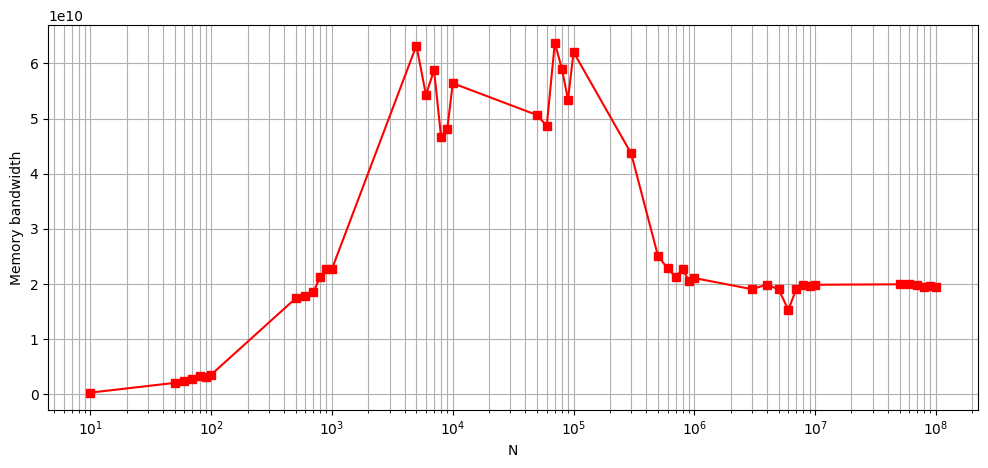

In [4]:
plt.rcParams["figure.figsize"] = (12,5)
plt.semilogx(nvals, memory_bandwidths, 'rs-')
plt.xlabel("N")
plt.ylabel("Memory bandwidth")
plt.grid(True, which='both', ls='-')
plt.show()

## Question 6

In [5]:
@numba.njit
def flop_72_benchmarker(y, a, x, b):
     for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        tmp3 = (ai*xi - bi)*(bi - xi)*(ai + xi)*(ai + xi)
        tmp4 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp5 = (ai*xi - bi)*(ai - bi)*(xi + bi)*(bi + xi)
        tmp6 = (ai*xi - bi)*(bi + ai)*(xi + xi)*(ai + xi)
        tmp7 = (ai*bi - xi)*(bi - xi)*(xi + ai)*(xi - bi)
        tmp8 = (ai*bi + xi)*(bi + xi)*(xi - ai)*(xi + bi)
        y[i] = ((tmp8*tmp6 + tmp7*tmp5 + bi*tmp4 - tmp3) + tmp2)*tmp1


@numba.njit
def flop_64_benchmarker(y, a, x, b):
     for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        tmp3 = (ai*xi - bi)*(bi - xi)*(ai + xi)*(ai + xi)
        tmp4 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp5 = (ai*xi - bi)*(ai - bi)*(xi + bi)*(bi + xi)
        tmp6 = (ai*xi - bi)*(bi + ai)*(xi + xi)*(ai + xi)
        tmp7 = (ai*bi - xi)*(bi - xi)*(xi + ai)*(xi - bi)
        y[i] = ((ai*tmp6 + tmp7*tmp5 + bi*tmp4 - tmp3) + tmp2)*tmp1


@numba.njit
def flop_32_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        tmp3 = (ai*xi - bi)*(bi - xi)*(ai + xi)*(ai + xi)
        y[i] = ((ai*ai + xi*xi + bi*bi - tmp3) + tmp2)*tmp1


@numba.njit
def flop_24_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        y[i] = ((ai*ai + xi*xi + bi*bi - tmp1) + tmp2)*tmp1


@numba.njit
def flop_16_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        y[i] = ((ai*ai + xi*xi + bi*bi - tmp) + tmp)*tmp


@numba.njit
def flop_4_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        y[i] = (((a[i] + b[i])*x[i]) + b[i])*a[i]


@numba.njit
def flop_8_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        y[i] = ((ai*ai + xi*xi + bi*bi - 3.14) + 3.14)*3.14


def flops(N, k, benchmarker):
    times = []
    a, b, x, y = make_data(N)
    for _ in range(5):
        main_time = 0
        niters = 0
        while (main_time < 0.1):
            t = time.perf_counter()
            benchmarker(y, a, b, x)
            t = time.perf_counter() - t
            niters += 1
            main_time += t
        times.append((main_time, niters))
    t = min(times)        
    flops = (N * t[1] * k)/t[0]
    return flops

In [6]:
nvals = np.array([10, 50, 60, 70, 80, 90, 100, 500, 600, 700, 800, 900, 1000, 5000, 6000, 7000, 8000, 9000, 10000, 
                  50000, 60000, 70000, 80000, 90000, 100000, 300000, 500000, 600000, 700000, 800000, 900000, 1000000,
                  3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000,
                  10000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], dtype=np.int64)

flops_72 = []
flops_64 = []
flops_32 = []
flops_24 = []
flops_16 = []
flops_8 = []
flops_4 = []

# dummy calls to warm up numba
a,b,x,y = make_data(100)
flop_72_benchmarker(y, a, x, b)
flop_64_benchmarker(y, a, x, b)
flop_32_benchmarker(y, a, x, b)
flop_24_benchmarker(y, a, x, b)
flop_16_benchmarker(y, a, x, b)
flop_8_benchmarker(y, a, x, b)
flop_4_benchmarker(y, a, x, b)


# benchmarking performance for different values of array size for 72 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_72.append(flops(nvals[i], 72, flop_72_benchmarker))

# benchmarking performance for different values of array size for 64 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_64.append(flops(nvals[i], 64, flop_64_benchmarker))

# benchmarking performance for different values of array size for 32 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_32.append(flops(nvals[i], 32, flop_32_benchmarker))

# benchmarking performance for different values of array size for 24 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_24.append(flops(nvals[i], 24, flop_24_benchmarker))

# benchmarking performance for different values of array size for 16 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_16.append(flops(nvals[i], 16, flop_16_benchmarker))

# benchmarking performance for different values of array size for 8 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_8.append(flops(nvals[i], 8, flop_8_benchmarker))

# benchmarking performance for different values of array size for 4 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_4.append(flops(nvals[i], 4, flop_4_benchmarker))

flops_72 = np.array(flops_72)
flops_64 = np.array(flops_64)
flops_32 = np.array(flops_32)
flops_24 = np.array(flops_24)
flops_16 = np.array(flops_16)
flops_8 = np.array(flops_8)
flops_4 = np.array(flops_4)

100%|██████████| 46/46 [00:39<00:00,  1.15it/s]


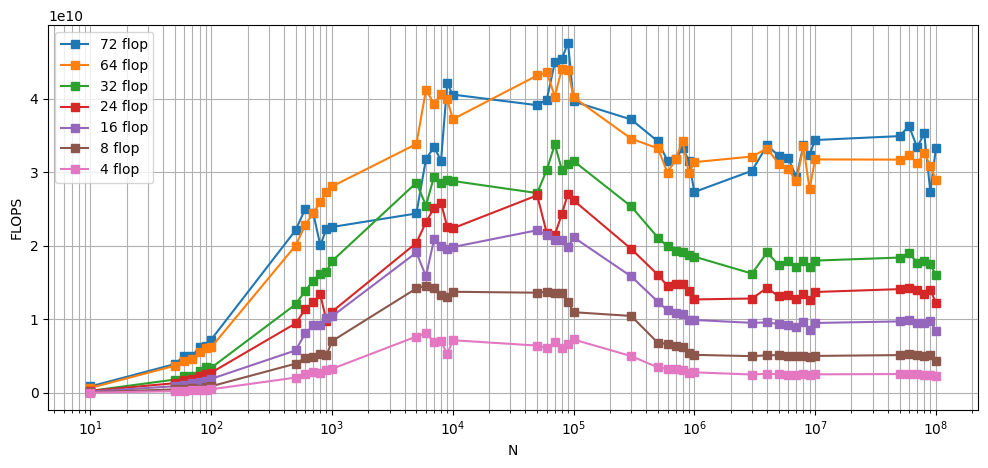

In [7]:
plt.rcParams["figure.figsize"] = (12,5)
plt.semilogx(nvals, flops_72, 's-', label='72 flop')
plt.semilogx(nvals, flops_64, 's-', label='64 flop')
plt.semilogx(nvals, flops_32, 's-', label='32 flop')
plt.semilogx(nvals, flops_24, 's-', label='24 flop')
plt.semilogx(nvals, flops_16, 's-', label='16 flop')
plt.semilogx(nvals, flops_8, 's-', label='8 flop')
plt.semilogx(nvals, flops_4, 's-', label='4 flop')
plt.xlabel("N")
plt.ylabel("FLOPS")
plt.legend()
plt.grid(True, which='both', ls='-')
plt.show()

In [8]:
print("Max GFLOPS for 72 FLOP benchmark code", max(flops_72)/1e9)
print("Max GFLOPS for 64 FLOP benchmark code", max(flops_64)/1e9)
print("Max GFLOPS for 32 FLOP benchmark code", max(flops_32)/1e9)
print("Max GFLOPS for 24 FLOP benchmark code", max(flops_24)/1e9)
print("Max GFLOPS for 16 FLOP benchmark code", max(flops_16)/1e9)
print("Max GFLOPS for 8 FLOP benchmark code", max(flops_8)/1e9)
print("Max GFLOPS for 4 FLOP benchmark code", max(flops_4)/1e9)

Max GFLOPS for 72 FLOP benchmark code 47.59406544374472
Max GFLOPS for 64 FLOP benchmark code 44.028873957219915
Max GFLOPS for 32 FLOP benchmark code 33.77028468187674
Max GFLOPS for 24 FLOP benchmark code 27.085831180798312
Max GFLOPS for 16 FLOP benchmark code 22.10384525855641
Max GFLOPS for 8 FLOP benchmark code 14.583781577100167
Max GFLOPS for 4 FLOP benchmark code 8.116975084788848


#### Thus we see that the maximum GFLOPS for our benchmark is 47.59 GFLOPS, which is about the same order as suggested by the datasheet.